# Multi-View-Majority-Vote-Learning-Algorithms-Direct-Minimization-of-PAC-Bayesian-Bounds

This Notebook contains everything necessary to reproduce the experiments in our paper:  

*Multi-View Majority Vote Learning Algorithms: Direct Minimization of PAC-Bayesian Bounds*

# Imports

In [4]:
# %pip install -r requirements.txt

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.core.defchararray import find, lower
from termcolor import colored
from datetime import datetime

# Scikit-learn
from sklearn import preprocessing
from sklearn.utils import check_random_state

# torch
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from mvpb import MultiViewMajorityVoteLearner, MajorityVoteLearner
from mvpb.util import uniform_distribution


# Import data
from data import (SampleData,
                           Nhanes,
                           MultipleFeatures,
                           MNIST_MV_Datasets,
                           Fash_MNIST_MV_Datasets,
                           EMNIST_Letters_MV_Datasets,
                           Mushrooms,
                           PTB_XL_plus,
                           Nutrimouse,
                           ReutersEN,
                           IS,
                           CorelImageFeatures,
                           NUS_WIDE_OBJECT,
                           ALOI,
                           train_test_split,
                           train_test_merge,
                           s1_s2_split,
                           multiclass_to_binary,
                           balance_dataset,
                           other_binary_options,
                           poison_dataset)

# Load and prepare the multiview datasets

In [2]:
dataset = MultipleFeatures(size="large")
X_train, y_train, X_test, y_test = dataset.get_data()
if isinstance(dataset, PTB_XL_plus):
    real_classes = dataset.get_real_classes(np.unique(y_train))

Xs_train = []
Xs_test = []
for xtr, xts in zip(X_train, X_test):
    scaler = preprocessing.MinMaxScaler().fit(xtr)
    Xs_train.append(scaler.transform(xtr))
    Xs_test.append(scaler.transform(xts))

X_train_concat = [np.concatenate(Xs_train, axis=1)]
X_test_concat = [np.concatenate(Xs_test, axis=1)]

np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [3]:
X_train[1].shape, y_train.shape, X_test[1].shape, y_test.shape

((60000, 200), (60000,), (10000, 200), (10000,))

<AxesSubplot:xlabel='0'>

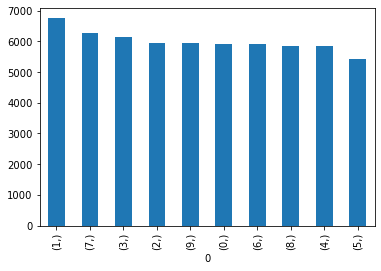

In [4]:
pd.DataFrame(y_train).value_counts().plot(kind="bar")

# Hyper-parameters setting

In [5]:
RUNS = range(10)

OPTIMIZE_LAMBDA_GAMMA = True
OPTIMIZE_ALPHA = True
ALPHA = [1, 1.1, 2]
# ALPHA = [1.1]
MAX_ITER = 1000


USE_DNDF = False
stump_config = {
    "name": "stump",
    "n_estimators": 100,
    "max_depth": 1,
    "max_features": 0.5,
}
weak_learners_config = {
    "name": "weak_learner",
    "n_estimators": 100,
    "max_depth": 3,
    "max_features": 0.5,
}
strong_learners_config = {
    "name": "strong_learner",
    "n_estimators": 100,
    "max_depth": 6,
    "max_features": 0.8,
}

CFG = [stump_config, weak_learners_config, strong_learners_config]
# CFG = [weak_learners_config]

EPOCHS = 15

TO_BINARY  = "ovo" # One of ["ovr", "ovo", "other",  None]
label_1 = 4
label_2 = 9

POISON = False

USE_UNLABELED = True
s_labeled_sizes = [0.1, 0.2, 0.3, 0.4, 0.5] if USE_UNLABELED else [1]
# s_labeled_sizes = [0.05] if USE_UNLABELED else [0.1]

BOUNDS = ['Uniform', 'PBkl', 'PBkl_inv', 'TND_DIS', 'TND_DIS_inv', 'TND', 'TND_inv', 'DIS', 'DIS_inv', 'Cbound', 'C_TND']
# BOUNDS = ['Uniform', 'PBkl', 'PBkl_inv', 'TND_DIS', 'TND_DIS_inv', 'TND', 'TND_inv', 'DIS', 'DIS_inv', 'C_TND']

m = y_train.size #350
test_size = 1 - (m  / (y_test.size+y_train.size))

experiments = {}
if OPTIMIZE_ALPHA:
    for s_labeled_size in s_labeled_sizes:
        experiments[s_labeled_size] = {}
        for cfg in CFG:
            experiments[s_labeled_size][cfg["name"]] = []
else:
    for s_labeled_size in s_labeled_sizes:
        experiments[s_labeled_size] = {}
        for alpha in ALPHA:
            experiments[s_labeled_size][alpha] = {}
            for cfg in CFG:
                experiments[s_labeled_size][alpha][cfg["name"]] = []

In [6]:
experiments, label_1

({0.1: {'stump': [], 'weak_learner': [], 'strong_learner': []},
  0.2: {'stump': [], 'weak_learner': [], 'strong_learner': []},
  0.3: {'stump': [], 'weak_learner': [], 'strong_learner': []},
  0.4: {'stump': [], 'weak_learner': [], 'strong_learner': []},
  0.5: {'stump': [], 'weak_learner': [], 'strong_learner': []}},
 4)

In [7]:
# if POISON:
#     Xs_train, y_train = poison_dataset(Xs_train, y_train, poison_label=label_1, target_label=label_2, target_view=3, num_samples=4000)

In [8]:
# Transform to binary OVR (One Vs Rest) or OVO (One Vs One) if needed
if TO_BINARY == "ovr":
    Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, type=TO_BINARY, label_1=label_1)
elif TO_BINARY == "ovo":
    Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, type=TO_BINARY, label_1=label_1, label_2=label_2)
elif TO_BINARY == "other":
    y_train, y_test = other_binary_options(dataset, y_train, y_test)
else:
    print(colored(f"WARNING: TO_BINARY={TO_BINARY}, continuing", 'yellow'))

In [9]:
np.unique(y_train), np.unique(y_test)

(array([0, 1]), array([0, 1]))

In [10]:
Xs_train[1].shape, y_train.shape, Xs_test[1].shape, y_test.shape

((11791, 200), (11791,), (1991, 200), (1991,))

# Running experiments

In [11]:
assert OPTIMIZE_ALPHA == False, "OPTIMIZE_ALPHA must be False"

before_merge = (Xs_train, y_train, Xs_test, y_test)
Xs, y = train_test_merge(Xs_train, y_train, Xs_test, y_test)
results_dir = "results-test"
os.makedirs(results_dir, exist_ok=True)
    

def metric_dict(mv_metric, v_metrics):
    metric_dict = {f"View{i+1}": v_metrics[i] for i in range(len(v_metrics)-1)}
    metric_dict.update({"Concatenated": v_metrics[-1]})
    metric_dict.update({"Multiview": mv_metric})
    return metric_dict

# iterate over the labeled data sizes #
for i, s1_size in enumerate(s_labeled_sizes):
    print(colored(f"############ Using {s1_size*100}% labeled data ############", 'black', on_color='on_blue'))
    s_labeled_dir = results_dir+f"/s_labeled-{int(s1_size*100)}"
    os.makedirs(s_labeled_dir, exist_ok=True)
### iterate over the alpha values ###
    
    for j, alpha in enumerate(ALPHA):
        print(colored(f"\t############ Using {alpha=} ############", 'black', on_color='on_blue'))
        alpha_dir = s_labeled_dir+ f"/alpha-{alpha}"
        os.makedirs(alpha_dir, exist_ok=True)
        
#### iterate over the configurations ####
        for k, config in enumerate(CFG):
            print(colored(f"\t\t############ Using {config['name']} ############", 'black', on_color='on_blue'))
            for run in RUNS:
                print(colored(f"\n----------------Run {run+1}---------------", 'blue'))

                # Shuffle and split the dataset into training and testing
                # if not dataset.split:
                Xs_train, y_train, Xs_test, y_test = train_test_split(Xs, y, test_size=test_size, random_state=run*(i+1)*(j+1)*(k+1))
                # else:
                # Xs_train, y_train, Xs_test, y_test = before_merge

                # Split the dataset into labeled and unlabeled
                Xs_train, y_train, UlX, _ = s1_s2_split(Xs_train, y_train, s1_size=s1_size, random_state=run*(i+1)*(j+1)*(k+1))
                X_train_concat = np.concatenate(Xs_train, axis=1)
                X_test_concat = np.concatenate(Xs_test, axis=1)
                    
                # instantiate multiview dNDF classifier
                dNDF_mv = MultiViewMajorityVoteLearner(nb_estimators=config["n_estimators"],
                                                        nb_views=len(Xs_train),
                                                        depth =config["max_depth"],
                                                        used_feature_rate=config["max_features"],
                                                        random_state=run,
                                                        epochs=EPOCHS,
                                                        use_dndf=USE_DNDF)
                
                # instantiate dNDF classifier for separate views and concatenated view
                dNDF_per_view = []
                for v in range(len(Xs_train)+1):
                    dNDF_per_view.append(MajorityVoteLearner(nb_estimators=config["n_estimators"],
                                                            depth =config["max_depth"],
                                                            used_feature_rate=config["max_features"],
                                                            random_state=run,
                                                            epochs=EPOCHS,
                                                            use_dndf=USE_DNDF))
                
                print("Training multiview classifier-------------------------------")
                dNDF_mv = dNDF_mv.fit(Xs_train, y_train)
                
                print("Training separate views classifiers-------------------------------")
                for v in range(len(Xs_train)):
                    dNDF_per_view[v] = dNDF_per_view[v].fit(Xs_train[v], y_train)

                print("Training concatenated view classifier-------------------------------")
                dNDF_per_view[-1] = dNDF_per_view[-1].fit(X_train_concat, y_train)
                
                
                # Optimize the posterior distributions for the each bound
                for bound in BOUNDS:
                    # Clear the posteriors (reset to uniform distribution)
                    dNDF_mv.clear_posteriors()
                    for v in range(len(Xs_train)+1):
                        dNDF_per_view[v].clear_posteriors()
                    
                    # use the unlabeled data for DIS
                    unlabeled_data, c_unlabeled_data = None, None
                    if USE_UNLABELED and bound in ['DIS', 'DIS_inv', 'TND_DIS', 'TND_DIS_inv',]:
                        unlabeled_data = UlX
                        c_unlabeled_data = np.concatenate(UlX, axis=1)
                    
                    if bound == "Uniform":
                        posterior_Qv = dNDF_mv.posterior_Qv
                        posterior_rho = dNDF_mv.posterior_rho
                        posterior_Qs = [dNDF_per_view[v].posterior_Q.tolist() for v in range(len(dNDF_per_view))]
                    else:
                        _, gibbs_risk, _ = dNDF_mv.mv_risk((Xs_train, y_train), incl_oob=False)
                        print(f"### Multiview classifier gibbs risk before Optim: {gibbs_risk}")
                        print(colored(f"Optimizing {bound} for multiview classifier-------------------------------", 'green'))
                        prev_time = datetime.now()
                        posterior_Qv , posterior_rho = dNDF_mv.optimize_rho(bound,
                                                                            labeled_data=(Xs_train, y_train),
                                                                            unlabeled_data=unlabeled_data,
                                                                            incl_oob=False,
                                                                            max_iter=MAX_ITER,
                                                                            optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                            optimize_alpha=False,
                                                                            alpha=alpha)
                        print(f"{dNDF_mv.alpha_v=}, {dNDF_mv.alpha=}")
                        print(colored(f"Optimization took {datetime.now() - prev_time} -------------------------------", 'yellow'))
                        
                        print(colored(f"Optimizing {bound} for separate views classifiers-------------------------------", 'green'))
                        posterior_Qs = []
                        for v in range(len(Xs_train)):
                            posterior_Q = dNDF_per_view[v].optimize_Q(bound,
                                                                            labeled_data=(Xs_train[v], y_train),
                                                                            unlabeled_data=unlabeled_data[v] if unlabeled_data else None,
                                                                            incl_oob=False,
                                                                            max_iter=MAX_ITER,
                                                                            optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                            alpha=alpha)
                            posterior_Qs.append(posterior_Q.tolist())
                        print(colored(f"Optimizing {bound} for concatenated classifier-------------------------------", 'green'))
                        posterior_Q_concat = dNDF_per_view[-1].optimize_Q(bound,
                                                                            labeled_data=(X_train_concat, y_train),
                                                                            unlabeled_data=c_unlabeled_data,
                                                                            incl_oob=False,
                                                                            max_iter=MAX_ITER,
                                                                            optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                            alpha=alpha)
                        posterior_Qs.append(posterior_Q_concat.tolist())
                        
                        _, gibbs_riska, _ = dNDF_mv.mv_risk((Xs_train, y_train), incl_oob=False)
                        print(f"### Multiview classifier gibbs risk after Optim: {gibbs_riska}")
                        # Compute the bound for the multiview classifier
                        print(colored(f"Optimization is done! -------------------------------", 'green'))
                    
                    print(colored(f"Computing the bound values ans risks -------------------------------", 'green'))
                    mv_bound, mv_grisk, mv_eS, mv_dS, mv_klqp, klrpi, ng, _, nd = dNDF_mv.bound(
                                        bound=bound,
                                        labeled_data=(Xs_train, y_train),
                                        unlabeled_data=unlabeled_data,
                                        incl_oob=False,
                                        alpha=alpha)
                    # Compute the risk of the multiview classifier
                    P, mv_risk = dNDF_mv.predict_MV(Xs_test, y_test)
                    
                    # Compute the bounds and risks for the separate views classifiers
                    v_bounds = []
                    v_grisks = []
                    v_eSs = []
                    v_dSs = []
                    v_klqps = []
                    for v in range(len(Xs_test)+1):
                        if v == len(Xs_test):
                            # Compute the bound for the concatenated view
                            concat_bound, grisk, eS, dS, klqp, _, _, _ = dNDF_per_view[v].bound(
                                        bound=bound,
                                        labeled_data=(X_train_concat, y_train),
                                        unlabeled_data=c_unlabeled_data,
                                        incl_oob=False,
                                        alpha=1)
                            v_bounds.append(concat_bound)
                        else:
                            # Compute the bound for the separate views
                            v_bound, grisk, eS, dS, klqp, _, _, _ = dNDF_per_view[v].bound(
                                            bound=bound,
                                            labeled_data=(Xs_train[v], y_train),
                                            unlabeled_data=unlabeled_data[v] if unlabeled_data else None,
                                            incl_oob=False,
                                            alpha=1)
                            v_bounds.append(v_bound)
                        v_grisks.append(grisk)
                        v_eSs.append(eS)
                        v_dSs.append(dS)
                        v_klqps.append(klqp)
                    
                    v_risks = [dNDF_per_view[v].predict(Xs_test[v], y_test)[1] for v in range(len(Xs_test))]
                    v_risks.append(dNDF_per_view[-1].predict(X_test_concat, y_test)[1])
                    # print(f"{dNDF_mv.posterior_Qv=} {dNDF_mv.posterior_rho=}")
                    

                    # Save the results
                    print(colored(f"Entering save and stats zone-------------------------------", 'green'))
                    views_risks = metric_dict(mv_risk, v_risks)
                    views_gibbs_risks = metric_dict(mv_grisk, v_grisks)
                    views_eSs = metric_dict(mv_eS, v_eSs)
                    views_dSs = metric_dict(mv_dS, v_dSs)
                    views_bounds = metric_dict(mv_bound, v_bounds)
                    views_klqps = metric_dict(mv_klqp, v_klqps)
                    views_kl_rhopi = metric_dict(klrpi, [np.nan for _ in range(len(Xs_test)+1)])
                    
                    list_posterior_Qv = [q.tolist() for q in posterior_Qv]
                    rounded_posterior_Qv = [["{:.9f}".format(q) for q in Q] for Q in list_posterior_Qv]
                    rounded_posterior_rho = ["{:.9f}".format(rho) for rho in posterior_rho.tolist()]
                    rounded_posterior_Qs = [["{:.9f}".format(q) for q in Q] for Q in posterior_Qs]
                    views_posterior_Qs = metric_dict(rounded_posterior_Qv, rounded_posterior_Qs)
                    views_posterior_rho = metric_dict(rounded_posterior_rho, [np.nan for _ in range(len(Xs_test)+1)])
                    
                    
                    assert len(views_risks) == len(views_bounds)
                    assert len(views_risks) == len(views_gibbs_risks) and len(views_risks) == len(views_eSs)
                    assert len(views_dSs) == len(views_eSs)
                    
                    for (kr, r), (kb, b) in zip(views_risks.items(), views_bounds.items()):
                        assert kr == kb # check if the keys are the same
                        exp = {"Run": run+1, 
                            "Bound_name": bound, 
                            "View": kr, 
                            "Risk": "{:.3f}".format(r),
                            "Gibbs_Risk": "{:.3f}".format(views_gibbs_risks[kr]),
                            "Bound": "{:.3f}".format(b),
                            "Join_Error": "{:.3f}".format(views_eSs[kr]),
                            "Disagreement": "{:.3f}".format(views_dSs[kr]),
                            "DIV_QP": "{:.3f}".format(views_klqps[kr]),
                            "DIV_RhoPi": "{:.3f}".format(views_kl_rhopi[kr]),
                            "alpha": alpha,
                            "n_labeled": ng,
                            "n_all": nd,
                            "Posterior_Qv": views_posterior_Qs[kr],
                            "Posterior_rho": views_posterior_rho[kr]}
                        experiments[s1_size][alpha][config["name"]].append(exp)
                    # TODO: add the posterior_Qv and posterior_rho to the experiment
                # del dNDF_mv, dNDF_per_view
                
            cfg_dir = alpha_dir + "/" + config["name"]
            os.makedirs(cfg_dir, exist_ok=True)
            experiment_df = pd.DataFrame(experiments[s1_size][alpha][config["name"]])
            # example: results/s_labeled-5/alpha-1/stump/MNIST_4vs9_20runs.csv
            file_name = f"{cfg_dir}/{dataset._name}_alpha-all_{label_1}vs{label_2}_{len(RUNS)}runs.csv"
            experiment_df.to_csv(file_name, sep=" ", index=False)

AssertionError: OPTIMIZE_ALPHA must be False

## for optimizable alpha

In [ ]:
assert OPTIMIZE_ALPHA == True, "OPTIMIZE_ALPHA must be True"

alpha = ALPHA[0]
before_merge = (Xs_train, y_train, Xs_test, y_test)
Xs, y = train_test_merge(Xs_train, y_train, Xs_test, y_test)
results_dir = "results-optim-alpha"
os.makedirs(results_dir, exist_ok=True)


def metric_dict(mv_metric, v_metrics):
    metric_dict = {f"View{i+1}": v_metrics[i] for i in range(len(v_metrics)-1)}
    metric_dict.update({"Concatenated": v_metrics[-1]})
    metric_dict.update({"Multiview": mv_metric})
    return metric_dict

# iterate over the labeled data sizes #
for i, s1_size in enumerate(s_labeled_sizes):
    print(colored(f"############ Using {s1_size*100}% labeled data ############", 'black', on_color='on_blue'))
    s_labeled_dir = results_dir+f"/s_labeled-{int(s1_size*100)}"
    os.makedirs(s_labeled_dir, exist_ok=True)
### iterate over the alpha values ###
        
#### iterate over the configurations ####
    for k, config in enumerate(CFG):
        print(colored(f"\t\t############ Using {config['name']} ############", 'black', on_color='on_blue'))
        for run in RUNS:
            print(colored(f"\n----------------Run {run+1}---------------", 'blue'))

            # Shuffle and split the dataset into training and testing
            # if not dataset.split:
            Xs_train, y_train, Xs_test, y_test = train_test_split(Xs, y, test_size=test_size, random_state=run*(i+1)*(k+1))
            # else:
            # Xs_train, y_train, Xs_test, y_test = before_merge

            # Split the dataset into labeled and unlabeled
            Xs_train, y_train, UlX, _ = s1_s2_split(Xs_train, y_train, s1_size=s1_size, random_state=run*(i+1)*(k+1))
            X_train_concat = np.concatenate(Xs_train, axis=1)
            X_test_concat = np.concatenate(Xs_test, axis=1)
                
            # instantiate multiview dNDF classifier
            dNDF_mv = MultiViewMajorityVoteLearner(nb_estimators=config["n_estimators"],
                                                    nb_views=len(Xs_train),
                                                    depth =config["max_depth"],
                                                    used_feature_rate=config["max_features"],
                                                    random_state=run,
                                                    epochs=EPOCHS,
                                                    use_dndf=USE_DNDF)
            
            # instantiate dNDF classifier for separate views and concatenated view
            dNDF_per_view = []
            for v in range(len(Xs_train)+1):
                dNDF_per_view.append(MajorityVoteLearner(nb_estimators=config["n_estimators"],
                                                        depth =config["max_depth"],
                                                        used_feature_rate=config["max_features"],
                                                        random_state=run,
                                                        epochs=EPOCHS,
                                                        use_dndf=USE_DNDF))
            
            print("Training multiview classifier-------------------------------")
            dNDF_mv = dNDF_mv.fit(Xs_train, y_train)
            
            print("Training separate views classifiers-------------------------------")
            for v in range(len(Xs_train)):
                dNDF_per_view[v] = dNDF_per_view[v].fit(Xs_train[v], y_train)

            print("Training concatenated view classifier-------------------------------")
            dNDF_per_view[-1] = dNDF_per_view[-1].fit(X_train_concat, y_train)
            
            
            # Optimize the posterior distributions for the each bound
            for bound in BOUNDS:
                # Clear the posteriors (reset to uniform distribution)
                dNDF_mv.clear_posteriors()
                for v in range(len(Xs_train)+1):
                    dNDF_per_view[v].clear_posteriors()
                
                # use the unlabeled data for DIS
                unlabeled_data, c_unlabeled_data = None, None
                if USE_UNLABELED and bound in ['DIS', 'DIS_inv', 'TND_DIS', 'TND_DIS_inv',]:
                    unlabeled_data = UlX
                    c_unlabeled_data = np.concatenate(UlX, axis=1)
                
                if bound == "Uniform":
                    posterior_Qv = dNDF_mv.posterior_Qv
                    posterior_rho = dNDF_mv.posterior_rho
                    posterior_Qs = [dNDF_per_view[v].posterior_Q.tolist() for v in range(len(dNDF_per_view))]
                else:
                    _, gibbs_risk, _ = dNDF_mv.mv_risk((Xs_train, y_train), incl_oob=False)
                    print(f"### Multiview classifier gibbs risk before Optim: {gibbs_risk}")
                    print(colored(f"Optimizing {bound} for multiview classifier-------------------------------", 'green'))
                    prev_time = datetime.now()
                    posterior_Qv , posterior_rho = dNDF_mv.optimize_rho(bound,
                                                                        labeled_data=(Xs_train, y_train),
                                                                        unlabeled_data=unlabeled_data,
                                                                        incl_oob=False,
                                                                        max_iter=MAX_ITER,
                                                                        optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                        optimize_alpha=OPTIMIZE_ALPHA,
                                                                        alpha=alpha)
                    print(f"{dNDF_mv.alpha_v=}, {dNDF_mv.alpha=}")
                    print(colored(f"Optimization took {datetime.now() - prev_time} -------------------------------", 'yellow'))
                    
                    print(colored(f"Optimizing {bound} for separate views classifiers-------------------------------", 'green'))
                    posterior_Qs = []
                    for v in range(len(Xs_train)):
                        posterior_Q = dNDF_per_view[v].optimize_Q(bound,
                                                                        labeled_data=(Xs_train[v], y_train),
                                                                        unlabeled_data=unlabeled_data[v] if unlabeled_data else None,
                                                                        incl_oob=False,
                                                                        max_iter=MAX_ITER,
                                                                        optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                        alpha=alpha)
                        posterior_Qs.append(posterior_Q.tolist())
                    print(colored(f"Optimizing {bound} for concatenated classifier-------------------------------", 'green'))
                    posterior_Q_concat = dNDF_per_view[-1].optimize_Q(bound,
                                                                        labeled_data=(X_train_concat, y_train),
                                                                        unlabeled_data=c_unlabeled_data,
                                                                        incl_oob=False,
                                                                        max_iter=MAX_ITER,
                                                                        optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                        alpha=alpha)
                    posterior_Qs.append(posterior_Q_concat.tolist())
                    
                    _, gibbs_riska, _ = dNDF_mv.mv_risk((Xs_train, y_train), incl_oob=False)
                    print(f"### Multiview classifier gibbs risk after Optim: {gibbs_riska}")
                    # Compute the bound for the multiview classifier
                    print(colored(f"Optimization is done! -------------------------------", 'green'))
                
                print(colored(f"Computing the bound values ans risks -------------------------------", 'green'))
                mv_bound, mv_grisk, mv_eS, mv_dS, mv_klqp, klrpi, ng, _, nd = dNDF_mv.bound(
                                    bound=bound,
                                    labeled_data=(Xs_train, y_train),
                                    unlabeled_data=unlabeled_data,
                                    incl_oob=False,
                                    alpha=alpha)
                # Compute the risk of the multiview classifier
                P, mv_risk = dNDF_mv.predict_MV(Xs_test, y_test)
                
                # Compute the bounds and risks for the separate views classifiers
                v_bounds = []
                v_grisks = []
                v_eSs = []
                v_dSs = []
                v_klqps = []
                for v in range(len(Xs_test)+1):
                    if v == len(Xs_test):
                        # Compute the bound for the concatenated view
                        concat_bound, grisk, eS, dS, klqp, _, _, _ = dNDF_per_view[v].bound(
                                    bound=bound,
                                    labeled_data=(X_train_concat, y_train),
                                    unlabeled_data=c_unlabeled_data,
                                    incl_oob=False,
                                    alpha=1)
                        v_bounds.append(concat_bound)
                    else:
                        # Compute the bound for the separate views
                        v_bound, grisk, eS, dS, klqp, _, _, _ = dNDF_per_view[v].bound(
                                        bound=bound,
                                        labeled_data=(Xs_train[v], y_train),
                                        unlabeled_data=unlabeled_data[v] if unlabeled_data else None,
                                        incl_oob=False,
                                        alpha=1)
                        v_bounds.append(v_bound)
                    v_grisks.append(grisk)
                    v_eSs.append(eS)
                    v_dSs.append(dS)
                    v_klqps.append(klqp)
                
                v_risks = [dNDF_per_view[v].predict(Xs_test[v], y_test)[1] for v in range(len(Xs_test))]
                v_risks.append(dNDF_per_view[-1].predict(X_test_concat, y_test)[1])
                # print(f"{dNDF_mv.posterior_Qv=} {dNDF_mv.posterior_rho=}")
                

                # Save the results
                print(colored(f"Entering save and stats zone-------------------------------", 'green'))
                views_risks = metric_dict(mv_risk, v_risks)
                views_gibbs_risks = metric_dict(mv_grisk, v_grisks)
                views_eSs = metric_dict(mv_eS, v_eSs)
                views_dSs = metric_dict(mv_dS, v_dSs)
                views_bounds = metric_dict(mv_bound, v_bounds)
                views_klqps = metric_dict(mv_klqp, v_klqps)
                views_kl_rhopi = metric_dict(klrpi, [np.nan for _ in range(len(Xs_test)+1)])
                
                list_posterior_Qv = [q.tolist() for q in posterior_Qv]
                rounded_posterior_Qv = [["{:.9f}".format(q) for q in Q] for Q in list_posterior_Qv]
                rounded_posterior_rho = ["{:.9f}".format(rho) for rho in posterior_rho.tolist()]
                rounded_posterior_Qs = [["{:.9f}".format(q) for q in Q] for Q in posterior_Qs]
                views_posterior_Qs = metric_dict(rounded_posterior_Qv, rounded_posterior_Qs)
                views_posterior_rho = metric_dict(rounded_posterior_rho, [np.nan for _ in range(len(Xs_test)+1)])
                
                
                assert len(views_risks) == len(views_bounds)
                assert len(views_risks) == len(views_gibbs_risks) and len(views_risks) == len(views_eSs)
                assert len(views_dSs) == len(views_eSs)
                
                for (kr, r), (kb, b) in zip(views_risks.items(), views_bounds.items()):
                    assert kr == kb # check if the keys are the same
                    exp = {"Run": run+1, 
                        "Bound_name": bound, 
                        "View": kr, 
                        "Risk": "{:.3f}".format(r),
                        "Gibbs_Risk": "{:.3f}".format(views_gibbs_risks[kr]),
                        "Bound": "{:.3f}".format(b),
                        "Join_Error": "{:.3f}".format(views_eSs[kr]),
                        "Disagreement": "{:.3f}".format(views_dSs[kr]),
                        "DIV_QP": "{:.3f}".format(views_klqps[kr]),
                        "DIV_RhoPi": "{:.3f}".format(views_kl_rhopi[kr]),
                        "alpha": dNDF_mv.alpha if kr == "Multiview" else alpha,
                        "alpha_v": dNDF_mv.alpha_v if kr == "Multiview" else np.nan,
                        "n_labeled": ng,
                        "n_all": nd,
                        "Posterior_Qv": views_posterior_Qs[kr],
                        "Posterior_rho": views_posterior_rho[kr]}
                    experiments[s1_size][config["name"]].append(exp)
                # TODO: add the posterior_Qv and posterior_rho to the experiment
            # del dNDF_mv, dNDF_per_view
            
        cfg_dir = s_labeled_dir + "/" + config["name"]
        os.makedirs(cfg_dir, exist_ok=True)
        experiment_df = pd.DataFrame(experiments[s1_size][config["name"]])
        # example: results/s_labeled-5/stump/MNIST_4vs9_20runs.csv
        file_name = f"{cfg_dir}/{dataset._name}_{label_1}vs{label_2}_{len(RUNS)}runs.csv"
        experiment_df.to_csv(file_name, sep=" ", index=False)

############ Using 10.0% labeled data ############
		############ Using stump ############

----------------Run 1---------------
Training multiview classifier-------------------------------
Training separate views classifiers-------------------------------
Training concatenated view classifier-------------------------------
Computing the bound values ans risks -------------------------------
Entering save and stats zone-------------------------------
### Multiview classifier gibbs risk before Optim: 0.3805235675980807
Optimizing PBkl for multiview classifier-------------------------------
	 Convergence reached after 51 iterations
dNDF_mv.alpha_v=array([1.2636781, 1.2654765, 1.2529683, 1.2463399, 1.2462959, 1.2646493],
      dtype=float32), dNDF_mv.alpha=array([1.2532412], dtype=float32)
Optimization took 0:00:02.279118 -------------------------------
Optimizing PBkl for separate views classifiers-------------------------------
	 Convergence reached after 102 iterations
	 Convergence re

#### Duplicating the results (not necessary) 

In [ ]:
# os.makedirs("results-dup", exist_ok=True)

# for s_labeled_size, size_exp in experiments.items():
#     s_labeled_dir = 'results-dup'+f"/s_labeled-{int(s_labeled_size*100)}"
#     os.makedirs(s_labeled_dir, exist_ok=True)
#     for alpha, alpha_exp in size_exp.items():
#         alpha_dir = s_labeled_dir+ f"/alpha-{alpha}"
#         os.makedirs(alpha_dir, exist_ok=True)
#         for cfg, cfg_exp in alpha_exp.items():
#             if cfg_exp == []:
#                 continue
#             cfg_dir = alpha_dir + "/" + cfg
#             os.makedirs(cfg_dir, exist_ok=True)
#             experiment_df = pd.DataFrame(cfg_exp)
#             # example: results-dup/s_labeled-5/alpha-1/stump/MNIST_4vs9_20runs.csv
#             file_name = f"{cfg_dir}/{dataset._name}_{label_1}vs{label_2}_{len(RUNS)}runs.csv"
#             experiment_df.to_csv(file_name, sep=" ", index=False)


In [14]:
df = pd.DataFrame(experiments[0.2][0.5]["weak_learner"])
df["Risk"] = df["Risk"].astype(float)
df["Bound"] = df["Bound"].astype(float)
# df['Bound'] = df['Bound'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
# df['Risk'] = df['Risk'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
df.head(20)

,Run,Bound_name,View,Risk,Gibbs_Risk,Bound,Join_Error,Disagreement,KL_QP,KL_RhoPi,n_labeled,n_all,Posterior_Qv,Posterior_rho
0,1,Uniform,View1,0.195,0.381,0.840,0.159,0.443,0.000,nan,2362.0,2362.0,"[0.010000000, 0.010000000, 0.010000000, 0.0100...",NaN
1,1,Uniform,View2,0.141,0.246,0.563,0.096,0.300,0.000,nan,2362.0,2362.0,"[0.010000000, 0.010000000, 0.010000000, 0.0100...",NaN
2,1,Uniform,View3,0.135,0.285,0.644,0.107,0.356,0.000,nan,2362.0,2362.0,"[0.010000000, 0.010000000, 0.010000000, 0.0100...",NaN
3,1,Uniform,View4,0.102,0.226,0.520,0.079,0.292,0.000,nan,2362.0,2362.0,"[0.010000000, 0.010000000, 0.010000000, 0.0100...",NaN
4,1,Uniform,View5,0.113,0.198,0.463,0.077,0.243,0.000,nan,2362.0,2362.0,"[0.010000000, 0.010000000, 0.010000000, 0.0100...",NaN
5,1,Uniform,View6,0.429,0.442,0.965,0.292,0.300,0.000,nan,2362.0,2362.0,"[0.010000000, 0.010000000, 0.010000000, 0.0100...",NaN
6,1,Uniform,Concatenated,0.082,0.194,0.454,0.063,0.261,0.000,nan,2362.0,2362.0,"[0.010000000, 0.010000000, 0.010000000, 0.0100...",NaN
7,1,Uniform,Multiview,0.072,0.297,0.670,0.101,0.394,0.000,0.000,2362.0,2362.0,"[[0.010000000, 0.010000000, 0.010000000, 0.010...","[0.166666672, 0.166666672, 0.166666672, 0.1666..."
8,1,PBkl,View1,0.259,0.326,0.737,0.172,0.307,2.005,nan,2362.0,2362.0,"[0.000437399, 0.002739322, 0.070695564, 0.0003...",NaN
9,1,PBkl,View2,0.164,0.186,0.439,0.093,0.185,0.668,nan,2362.0,2362.0,"[0.002922207, 0.023197588, 0.022175055, 0.0019...",NaN


In [15]:
df[df["Risk"] > df["Bound"]]

,Run,Bound_name,View,Risk,Gibbs_Risk,Bound,Join_Error,Disagreement,KL_QP,KL_RhoPi,n_labeled,n_all,Posterior_Qv,Posterior_rho


In [16]:
# agg_df = df.groupby(["Bound_name", "View"]).mean()
# agg_df

# Plot the data (use the plot.ipynb notebook it's well structured)

In [17]:
def plot_results_grid(exps, m, runs=len(RUNS), bounds=BOUNDS):

    sns.set_style(style="ticks")
    bounds_palette = sns.color_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()

    num_views = len(exps['View'].unique())
    num_cols = num_views // 2 + num_views % 2  # Calculate number of columns for subplots

    fig, ax = plt.subplots(2, num_cols, figsize=(14, 10), sharey=True)

    for i, view in enumerate(exps['View'].unique()):
        view_data = exps[exps['View'] == view]
        row = i // num_cols
        col = i % num_cols
        
        risk = view_data.groupby(["Bound_name", "View"])['Risk'].mean()
        # mean_risk = risk.median()
        # up_risk = mean_risk+risk.std()
        # lw_risk = mean_risk-risk.std()
        # print(mean_risk, up_risk, lw_risk)
        # Plot Bound
        sns.barplot(x='Bound_name', y='Bound', data=view_data, ax=ax[row, col], hue='Bound_name', hatch='.', palette=bounds_palette)        # Create a horizontal line at the median risk
        sns.barplot(x='Bound_name', y='Risk', data=view_data, ax=ax[row, col], hue='Bound_name', hatch='\\', palette=risk_palette)

        # ax[row, col].axhline(y=up_risk, color='b', linestyle='-', label='Q3 Risk')
        # ax[row, col].axhline(y=lw_risk, color='r', linestyle='--', label='Median Risk')
        # ax[row, col].axhline(y=mean_risk, color='g', linestyle='-', label='Q1 Risk')
        ax[row, col].set_title(f'{view}')
        ax[row, col].set_xlabel('Bounds')
        ax[row, col].set_ylabel('Means')
        plt.setp( ax[row, col].xaxis.get_majorticklabels(), rotation=70 )

        

    # handles, labels = ax[0,0].get_legend_handles_labels()
    # labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]
    # ax[0, 0].legend(handles, labels, title='Bounds', loc='upper right', fontsize='medium')
    fig.suptitle(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    fig.tight_layout()
    plt.show()

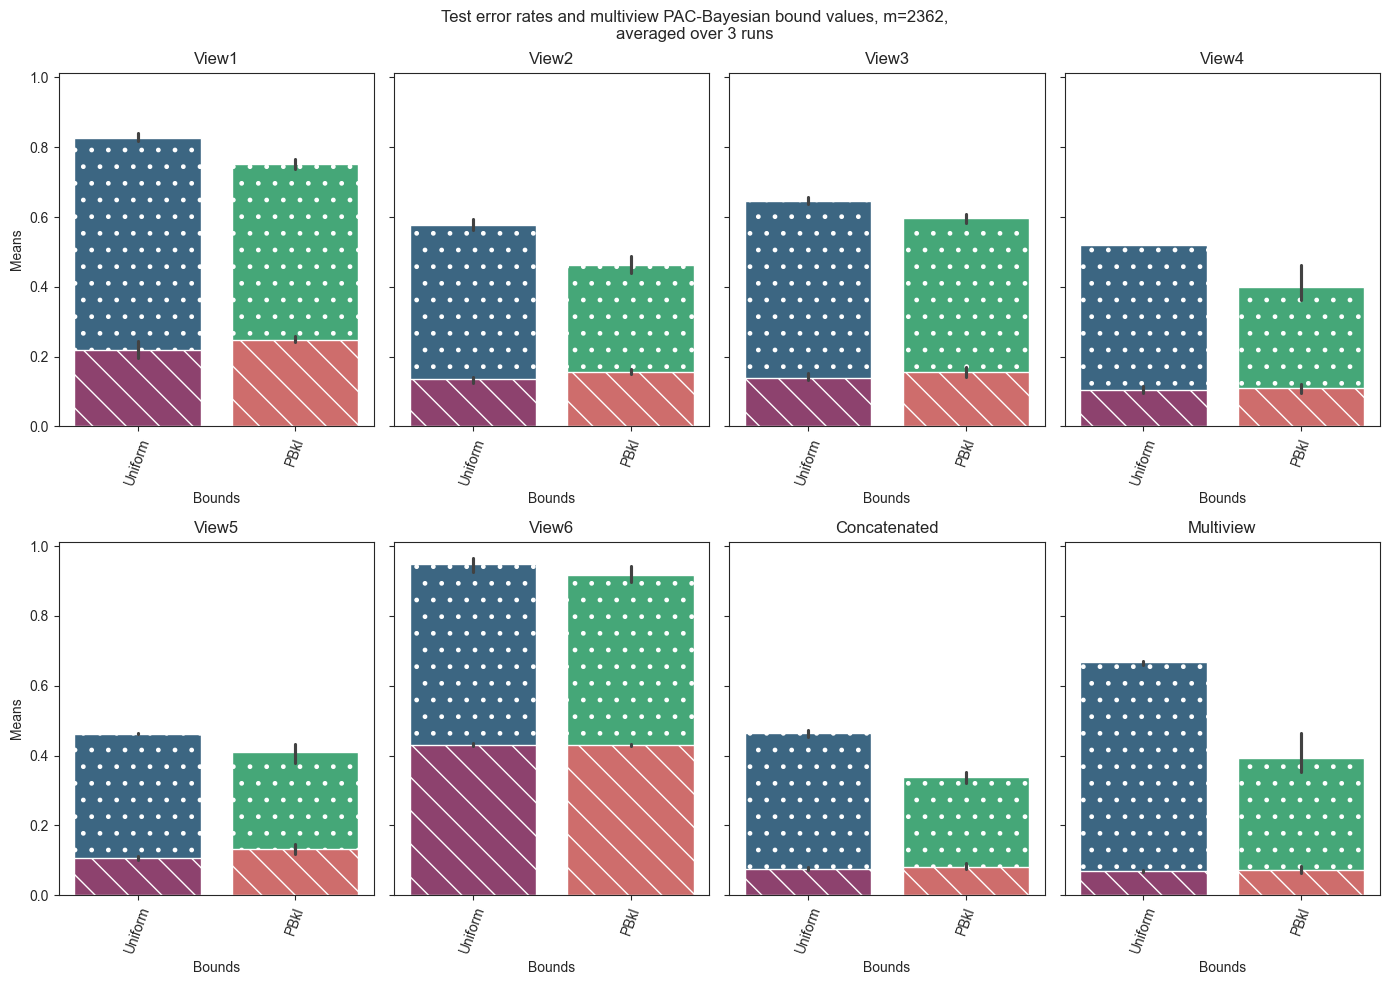

In [18]:
plot_results_grid(df, len(Xs_train[0]))

In [ ]:
posterior_rho
sns.heatmap(posterior_Qv, fmt=".2f", cmap='viridis')

In [ ]:
def plot_results(experiments, m, runs=len(RUNS), bounds=BOUNDS):
    sns.set_style(style="ticks")
    bounds_palette = sns.mpl_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()
    
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Bound', errorbar="sd", width=0.8, hatch='.', palette=bounds_palette)
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Risk', errorbar="sd", width=0.8, hatch='\\', palette=risk_palette)

    plt.title(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    plt.xlabel('Views')
    plt.ylabel('Means')
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]

    # Creating a unified legend for both plots
    plt.legend(handles, labels, title="Bounds and risks", loc='upper right', fontsize='medium')
    plt.tight_layout() 
    plt.gcf().set_size_inches(24, 12)
    plt.show()

In [ ]:
plot_results(df, len(Xs_train[0]))